# Predicting the S&P 500 Stock Price
### Based on Previous S&P 500 Historical Data

#### By Dhruv Rachakonda

In this exporatory data analysis, I will be conducting an extensive EDA, and attempt to predict the S&P 500 Price for the next day

Let us begin by important the yfinance package, which will download up to date financial data as needed. We will also import other neccesary libraries 

In [228]:
import yfinance as yf
import seaborn as sb
import matplotlib.pyplot as mt
import pandas as pd
import datetime as dt
from pytz import timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


Now, let us initilize a "ticker class" which will allow us to download data for a specific single symbol.

The GSPC symbol is the S&P 500's symbol

Let us get the maximum amount of data availible for the S&P 500

In [229]:
s_p500 = yf.Ticker("^GSPC")

In [230]:
s_p500 = s_p500.history(period = "max")

In [231]:
s_p500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [232]:
s_p500.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-08 00:00:00-04:00,5572.750000,5583.109863,5562.509766,5572.850098,3185670000,0.0,0.0
2024-07-09 00:00:00-04:00,5584.240234,5590.750000,5574.569824,5576.979980,3232920000,0.0,0.0
2024-07-10 00:00:00-04:00,5591.259766,5635.390137,5586.439941,5633.910156,3336100000,0.0,0.0
2024-07-11 00:00:00-04:00,5635.209961,5642.450195,5576.529785,5584.540039,4020950000,0.0,0.0
2024-07-12 00:00:00-04:00,5590.759766,5655.560059,5590.439941,5615.350098,3700280000,0.0,0.0


In [233]:
s_p500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

We can see that we have the following columns

<ul>
    <li><b>Date</b>: The trading day in question</li>
    <li><b>Open</b>: The price that the stock started at for the trading day</li>
    <li><b>Close</b>: The price that the stock ended at for the trading day</li>
    <li><b>High</b>: The highest point that the stock had ever reached for the trading day</li>
    <li><b>Low</b>: The lowest point that the stock had ever reached for the trading day</li>
</ul>

### Data Examination and Cleaning
We will now examine the data and format it as needed to better fit our model. 

Let us first plot the dataset. I am using Seaborn to plot this.

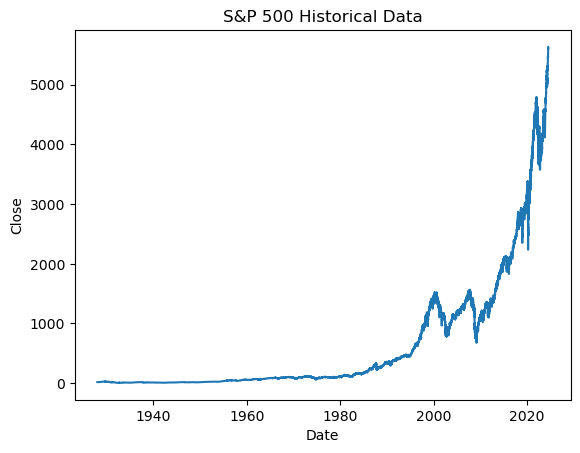

In [234]:
s_p_plot = sb.lineplot(data = s_p500, x="Date", y="Close").set_title("S&P 500 Historical Data")

In this plot, we can see some interesting points in history, such as 9/11 in 2001, the major recession in 2008, and the Coronavirus pandemic of 2020. These are all points where the line visibly dropped.

There are some columns that will not be relevent to the training of our model. We will remove these in order to speed up the processing and training time of our data and model. 

Firstly, the dividends model is not relevent in predicting the stock price based on this data, so we will delete it. 

In [235]:
del s_p500["Dividends"]

Addiitionaly, the Stock Splits column is also irrelevent, so we will delete it. 

In [236]:
del s_p500["Stock Splits"]

Both of these columns are more relevent for individual stocks, rather than a holisitic analysis of an index such as the S&P 500. We will keep volume since the number of stocks traded on a given day is crucial in predicting the next day's stock price.

We also need to determine and construct our target, or the actual metric that we will be predicting. We simply want to predict here, will the price go up or down.
<br> 
<br>
Predicting exact values (for example, we predict the stock price will be X dollars tomorrow) is a problematic method. This is because the model can still be extremely accurate at predicting exact values, but it is possible to still lose profit. The objective here is to predict a good directionality on whether or not to invest in a specific stock or ETF. 
<br>
<br>
Let us create a column to represent tomorrow's price (our ŷ-value essentially). We can use the shift function for this to shift all the values up and to the left into a new column. This will make it easier to compare the price between two days

In [237]:
s_p500["Tomorrow"] = s_p500["Close"].shift(-1)

In [238]:
s_p500.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000


Now, we need to initialize the actual target, which is whether or not the price tomorrow is greater that the price today on any given day. We will do this in the form of a boolean column.

In [239]:
s_p500["Target"] = (s_p500["Tomorrow"] > s_p500["Close"]).astype(int) #im converting to int since most ML algorithms use 0s and 1s

In [240]:
s_p500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


We have now initilized our target column. Now, we have a column where True represents a day where the stock price did in fact increase over night, and false if otherwise. 

We also want to avoid using data before 1990, as financial data may have shifted on an extreme level, and may therefore bias our model. 

In [241]:
s_p500 = s_p500.loc["1990-01-01":].copy()

In [254]:
s_p500.tail()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2024-07-08 00:00:00-04:00,5572.750000,5583.109863,5562.509766,5572.850098,3185670000,5576.979980,1
2024-07-09 00:00:00-04:00,5584.240234,5590.750000,5574.569824,5576.979980,3232920000,5633.910156,1
2024-07-10 00:00:00-04:00,5591.259766,5635.390137,5586.439941,5633.910156,3336100000,5584.540039,0
2024-07-11 00:00:00-04:00,5635.209961,5642.450195,5576.529785,5584.540039,4020950000,5615.350098,1
2024-07-12 00:00:00-04:00,5590.759766,5655.560059,5590.439941,5615.350098,3700280000,NaN,0


### Development and Assesment of the Predicition Model

To start, we will be using the Random Forest algorithm from SciKit Learn. Random Forest allows us to not only quickly make predictions due to its logarithmic runtime nature, but also allows us to make non-linear correlations such as the one in the dataset due to the multiple decision trees that are constructed during the training process.  

Let us start by training our model

In [272]:
# Chose n_estimators = 100 to have a large enough number of trees in the forest for robustness without excessive computation.
# Chose min_samples_split = 100 to ensure each internal node has at least 100 samples before it can be split, aiming to control overfitting and promote generalization.
# Chose random_state = 1 for reproducibility, ensuring the results are consistent across different runs of the model.
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1) 

#our training set will the rows that are not in the last 100 rows to train
#our testing set will be the last 100 rows

train = s_p500.iloc[:-100]
test = s_p500.iloc[-100:]


#We will exclude tomorrow in target in the prediction factors, as this will bias our data
predictors = ["Close", "Volume", "Open", "High", "Low"]

#We will train now using the predictors and the output as the target
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)


Now, let us assess how this model did. We will use the precision score, and the SciKit Learn precision_score library can help us do this.

In [273]:
preds = model.predict(test[predictors])

In [274]:
preds = pd.Series(preds, index=test.index)

In [275]:
precision_score(test["Target"], preds, average='micro')

0.44

This is a terrible score, and it would actually be more advisable to trade against this algorithm than with it. 

### Backtesting

We want a way to test over multiple years of data, as 100 data points is not a solidified metric for testing a machine learning model of this nature 

To do this, we'll create a prediction function which wraps testing into one function

In [280]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

Then, we'll create a backtest function which takes in the S&P 500 data as well the model and the predictors, as well as a start and step value. The start value allows us to tell us how far back to go to train, and the step value tells us how far forward to step when testing.  

In [281]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [285]:
predictions = backtest(s_p500, model, predictors)

Let us see how many times the algorithm advised of a fall or rise in the market

In [286]:
predictions["Predictions"].value_counts()

0    3602
1    2596
Name: Predictions, dtype: int64

In [288]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

This was an improvement, but still not very good. Now let us see the number of times the market actually went up

In [289]:
predictions["Target"].value_counts()/predictions.shape[0]

1    0.535495
0    0.464505
Name: Target, dtype: float64

This is still a terrible measure, but now that we have a backtester, we have more confidence in our model and the ability to test it. 

### Adding Predictors to Improve Accuracy

To better create better predictions, we'll add extra metric for averages based on different days. So basically, average of last 2 days, 5 days, 60 days, 250, and 1000 days. We will also add a rolling sum for the number of times a stock price went up in the last X (where x is the given horizon) days

In [294]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = s_p500.rolling(horizon).mean()
    
    #from here, we'll calculate a rolling average to better predict in our model
    ratio_column = f"Close_Ratio_{horizon}"
    s_p500[ratio_column] = s_p500["Close"] / rolling_averages["Close"]
    
    #trend is number of days in x days that stock price actually went up
    trend_column = f"Trend_{horizon}"
    s_p500[trend_column] = s_p500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [296]:
s_p500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are some days where there are no previous days to calculate these rolling metrics, which is what these NAN values are. We'll drop these to avoid contamininating the data. 

In [297]:
s_p500 = s_p500.dropna()

In [298]:
s_p500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


We start now at 1993 since the metrics require at least two years of data. 

### Reattempting Training on New Data

Let us first adjust the hyperparamters on the Random Forest Algorithm

In [299]:
#I decided to increase the number of estimators, but reduce the number of sample splits 
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1) 

In [300]:
#I also want to return a better metric of probability instead of a yes or no
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    #I am also increasing the tolerance to 0.6. Basically reduce the number of trades and reduce risk through overfitting
    preds[preds >= .6] = 1
    preds[preds <= .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [301]:
predictions = backtest(s_p500, model, new_predictors)

Let us see the value counts for these predictions now

In [302]:
predictions["Predictions"].value_counts()

0.0    4359
1.0     838
Name: Predictions, dtype: int64

The algorithm is much more careful now, predicting that more days are considered to be days that the market will fall. This is likely due to the 0.6 tolerance that we have put in place, thus inducing more strictness into what is a good market day. 

In [303]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5751789976133651

This means that 57% of the time, you would be correct to use this algorithm in purchasing a stock. In theory, this would actually provide a profit.

### Summary

<ul>
    <li><b>Cleaning and Analysis</b>: Cleaned the data, formatted it and analysed it as well</li>
    <li><b>Initial Testing</b>: Utilized the random forest algorithm. Proved to be 44% accurate.</li>
    <li><b>Back Testing</b>: Added a backtesting feature to test on longer periods of data</li>
    <li><b>Added Additional Predictions</b>: Added rolling averages and sums to improve the accuracy of the data</li>
    <li><b>Final Result</b>: 13% increase in accuracy, and on average will return a profit if used to determine when to buy or sell based on this algorithm alone</li>
</ul>